In [1]:
import math
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn

In [2]:
def sample_covariance(neuron_one, trainpoint_one, neuron_two, trainpoint_two, yy):
    '''Sample covariance, formulas as in https://en.wikipedia.org/wiki/Sample_mean_and_covariance'''
    one = yy[:, neuron_one-1, trainpoint_one-1]
    two = yy[:, neuron_two-1, trainpoint_two-1]
    # nn, mean_one, mean_two, sum = len(one), np.mean(one), np.mean(two), 0.0
    # for pos in range(nn):
    #     sum += (one[pos]-mean_one)*(two[pos]-mean_two)
    cov = np.cov(one, two)[0, 1]

    return cov

def K_xx(trainpoint_one, trainpoint_two, cw, xx):
    '''Metric (4.8) calculation'''
    one, two = xx[:,trainpoint_one-1],xx[:,trainpoint_two-1]
    # nn, sum = len(one), 0.0
    # for pos in range(nn):
    #     sum += one[pos]*two[pos]
    dot = one.dot(two)

    return dot*cw/len(one)

In [3]:
class FeedForwardNet(nn.Module):

    def __init__(self, n0=3, nk=10, nl=3, l=3, bias_on=False):
        '''n0: # dimension of x
           nk: # hidden nodes
           nl: # dimension of y
           l: # number of layers
           bias_on: # whether bias is included into linear preactivations'''
        super().__init__()
        self.n0=n0
        self.nk=nk
        self.nl=nl
        self.bias_on = bias_on
        self.log_level = None
        self.linears = []
        self.cw = None  # assume layer-independent cw
        self.G01 = []  # record the flow of metric G (stochastic, 4.36)
        self.G00 = []
        self.G11 = []
        print("FeedForwardNet created with n0={}, nk={}, nl={}, l={}, bias_on={}".format(n0, nk, nl, l, bias_on))

        self.linears.append(nn.Linear(n0, nk, bias=bias_on))
        if l > 2:
            for _ in range(2, l):
                self.linears.append(nn.Linear(nk, nk, bias=bias_on))
        if l > 1:
            self.linears.append(nn.Linear(nk, nl, bias=bias_on))

    def set_log_level(self, value):
        self.log_level = value

    def get_log_level(self):
        if self.log_level in ("debug", "info", "warning", "error"):
            return self.log_level
        else:
            return "info"

    def init_weights(self, cb=1.0, cw=1.0):
        if self.get_log_level() == "debug":
            print("FeedForwardNet weights initialised with cb={}, cw={}".format(cb, cw))

        #Weight initialisation as in 2.19, 2.20
        self.cw = cw
        n_prev = self.n0
        for linear in self.linears:
            nn.init.normal_(linear.weight, mean = 0., std = math.sqrt(cw/n_prev))
            n_prev = linear.weight.size()[0]
            if self.bias_on and cb > 0:
                nn.init.normal_(linear.bias, mean = 0., std = math.sqrt(cb))
                

In [4]:
class ParametricReLUNet(FeedForwardNet):
    def __init__(self, n0=3, nk=10, nl=3, l=3, bias_on=False):
        super().__init__(n0, nk, nl, l, bias_on)
        self.slope_positive = None
        self.slope_negative = None

    def set_slopes(self, slope_positive = 1.0, slope_negative = 0.25):
        self.slope_positive = slope_positive
        self.slope_negative = slope_negative

    def PReLU(self, input: Tensor) -> Tensor:
        # for pos in range(input.size(dim=0)):
        #     input[pos] = input[pos] * (self.slope_positive if input[pos] >= 0 else self.slope_negative)
        input = torch.where(input >= 0, self.slope_positive * input, self.slope_negative * input)
        return input

    def forward(self, xx):
        if self.slope_positive == None:
            raise Exception("To use forward set slopes with call ParametricReLUNet.set_slopes(...)")

        self.G01 = [K_xx(1, 2, self.cw, xx)]  # start recording metric G from G_1 (4.8)
        self.G00 = [K_xx(1, 1, self.cw, xx)]
        self.G11 = [K_xx(2, 2, self.cw, xx)]
        
        zk = torch.tensor(xx.transpose(), dtype=torch.float32)
        for linear in self.linears[:-1]:
            zk = linear(zk)
            zk = self.PReLU(zk)
            zk_ = zk.detach().numpy()
            assert zk_.shape[0] == 2, zk_.shape
            self.G01.append(zk_[0].dot(zk_[1])/zk_.shape[1] * self.cw)  # keep recording metric G (stochastic, 4.36)
            self.G00.append(zk_[0].dot(zk_[0])/zk_.shape[1] * self.cw)
            self.G11.append(zk_[1].dot(zk_[1])/zk_.shape[1] * self.cw)
        zk = self.linears[-1](zk)
        return zk.detach().numpy().transpose()

In [5]:
#Test for PReLU-activation implementation

testPReLU = ParametricReLUNet()
testPReLU.set_slopes(0.5, 0.2)
resultPReLU = testPReLU.PReLU(torch.tensor(np.array([1.1,-2.2]), dtype=torch.float32))
print(resultPReLU)

FeedForwardNet created with n0=3, nk=10, nl=3, l=3, bias_on=False
tensor([ 0.5500, -0.4400])


In [6]:
'''n0: # dimension of x
    nk: # hidden nodes
    nl: # dimension of y
    l: # number of layers
    nd: # number of points in train-set'''
n0,nk,nl,l=3,10000,2,10
nd = 2
'''slope_plus, slope_minus: # slopes for Relu
    experiments_number: # number of experiments'''
slope_plus, slope_minus=1.0, 0.5
experiments_number = 50

testNet = ParametricReLUNet(n0=n0,nk=nk,nl=nl,l=l)
testNet.set_log_level("info")
testNet.set_slopes(slope_plus, slope_minus)
xx = np.random.normal(size=(n0, nd)).astype(np.float32)
yy = np.zeros((experiments_number, nl, nd))
cw= 2.0/(slope_plus**2.0 + slope_minus**2.0)

G01_records = []
G00_records = []
G11_records = []

#for each experiment re-initialisation of the weights with recalculation
for experiment_number in range(experiments_number):
    #weights distribution is initialisied as in (5.67)
    testNet.init_weights(0, cw)
    # for col in range(nd):
    #     res = testNet.forward(xx[:,col])
    #     for row in range(nl):
    #         yy[experiment_number,row,col] = res[row]
    res = testNet.forward(xx)
    yy[experiment_number] = res
    G01_records.append(testNet.G01.copy())
    G00_records.append(testNet.G00.copy())
    G11_records.append(testNet.G11.copy())
    
    print('-', end='')

#print("xx:", xx)
#print("yy:", yy)

FeedForwardNet created with n0=3, nk=10000, nl=2, l=10, bias_on=False
--------------------------------------------------

In [7]:
for neuron1 in range(1, nl+1):
      for neuron2 in range(neuron1, nl+1):
            for trainpoint1 in range(1, nd+1):
                  for trainpoint2 in range(1 if neuron1 != neuron2 else trainpoint1, nd+1):
                        print("Sample covariance between neuron {}, trainpoint {} and neuron {}, trainpoint {}: {}"\
                              .format(neuron1, trainpoint1, neuron2, trainpoint2\
                                      , sample_covariance(neuron1,trainpoint1,neuron2,trainpoint2,yy)))

Sample covariance between neuron 1, trainpoint 1 and neuron 1, trainpoint 1: 3.1232390573423507
Sample covariance between neuron 1, trainpoint 1 and neuron 1, trainpoint 2: 0.9234564116227921
Sample covariance between neuron 1, trainpoint 2 and neuron 1, trainpoint 2: 0.7373899585219025
Sample covariance between neuron 1, trainpoint 1 and neuron 2, trainpoint 1: 0.25158737679745147
Sample covariance between neuron 1, trainpoint 1 and neuron 2, trainpoint 2: 0.09995060342725966
Sample covariance between neuron 1, trainpoint 2 and neuron 2, trainpoint 1: 0.022210190723646293
Sample covariance between neuron 1, trainpoint 2 and neuron 2, trainpoint 2: -0.020482906202424767
Sample covariance between neuron 2, trainpoint 1 and neuron 2, trainpoint 1: 2.83977538003494
Sample covariance between neuron 2, trainpoint 1 and neuron 2, trainpoint 2: 0.6208343942473604
Sample covariance between neuron 2, trainpoint 2 and neuron 2, trainpoint 2: 0.6208703405299396


In [8]:
for trainpoint1 in range(1, nd+1):
    for trainpoint2 in range(trainpoint1, nd+1):
        print("Metric (4.8) for trainpoint {} and trainpoint {}: {}"\
              .format(trainpoint1, trainpoint2, K_xx(trainpoint1, trainpoint2, cw, xx)))

Metric (4.8) for trainpoint 1 and trainpoint 1: 2.3009549458821614
Metric (4.8) for trainpoint 1 and trainpoint 2: 0.20525433222452802
Metric (4.8) for trainpoint 2 and trainpoint 2: 0.56636168162028


In [9]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'G01')

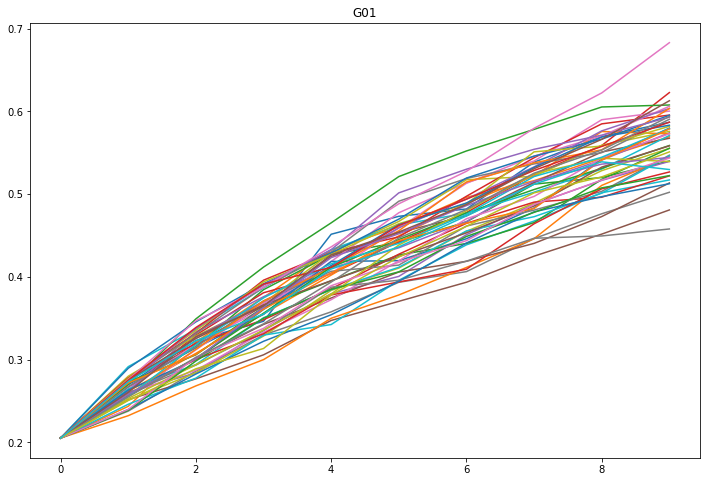

In [13]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G01_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G01")

Text(0.5, 1.0, 'G00')

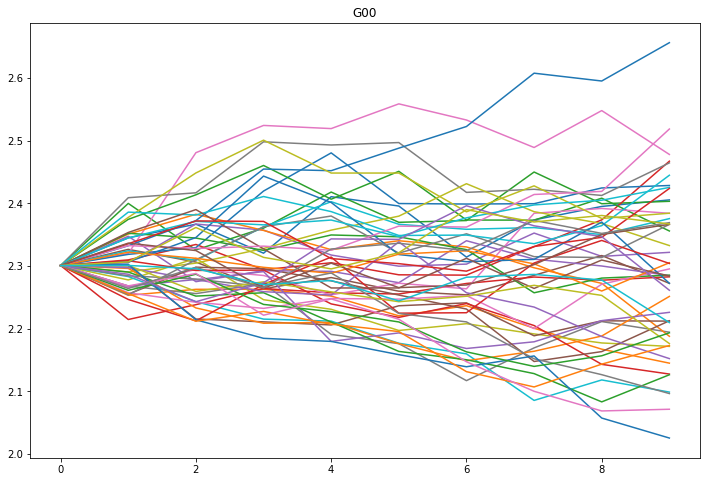

In [14]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G00_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G00")

Text(0.5, 1.0, 'G11')

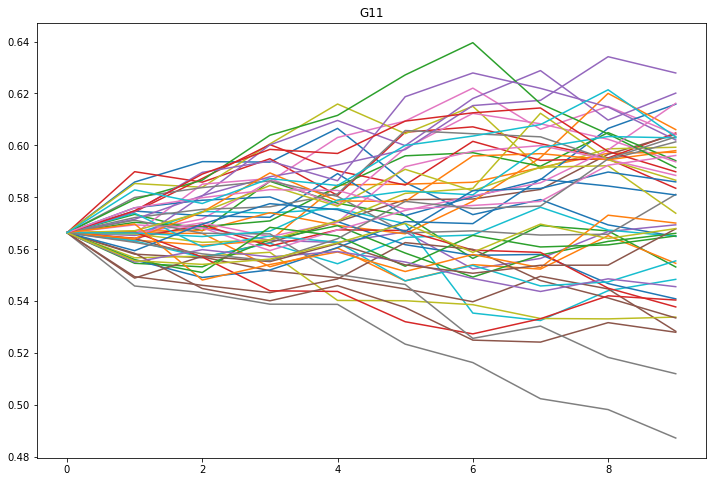

In [15]:
plt.figure(figsize=(12, 8))
for i, Gs in enumerate(G11_records):
    plt.plot(Gs, label=f"experiment {i}")
#plt.legend()
plt.title("G11")